## Data Generator 
Created: February 26, 2020

This series of notebooks generate synthetic data for different components of the food supply chain. It models activities like restaurant orders using normal distributions with parameters number of events $n$, mean $\mu$, and standard deviation $\sigma$.  After the distribution or distributions are is created, a function samples the distribution and generates $n$ events for a specific type of event: telemetry event, event enrichment, or session enrichment event. The events are written to a text file and exported locally. 

This notebook specifically allows a user to specify any number of parameters (3 for normal distribution) for any number of distributions using a textfile. This generates events that are saved and plots a histogram of those events. 

The outputs of the events follows the data model described in this document: https://zumepizza.atlassian.net/wiki/spaces/TERA/pages/659325236/Examples+of+Customer+Data+throughout+the+Pipeline

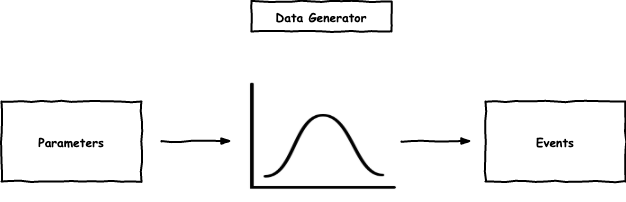

In [1]:
from IPython.display import Image
Image(filename="/Users/newtonkwan/Documents/zume/data-generator/data_generator_pipeline.png")

### Version 1 (2/6/20)
- Shows how to create a normal distribution
- Outputs three text files, each with one of example of the following: telemetry event, enriched event, and enriched session. 

### Version 2 (2/10/20)
- Same as version 1 including the following
- Write three functions that allow a user to specify the number of events to simulate for each of the three kinds of events. The outputs are three text files, each with n number of events of the following kind: telemetry event, enriched event, and enriched session. 

### Version 3 (2/10/20)
- Same as version 2 including the following
- Written a function that generates synthetic data for tomato harvests by month that follows a normal distribution whose parameters can be user specified. 
- The event enrichment events generator can generate 100,000 events every 5 seconds and write those events in about 5 seconds for a total of 10 seconds per 100,000 events. 

### Version 4 (2/12/20)
- Same as version 3 including the following
- Written a function that generates synthetic data for Tito's Tacos that has two normal distributions to describe lunch and dinner orders using 6 user specfied parameters (number of lunch orders, number of dinner orders, lunch mean, dinner mean, lunch standard deviation, and dinner standard deviation) to generate data. 
- Added details Part C to telemetry events for orders because I did not consider order details to be event enrichment.
- Plotted a denormlaized normal distribution (amplitude * pdf) rather than normalizing the histogram and fitting it to a pdf because it is more intuitive to view orders of the y-axis than a probability density for number of orders 

### Version 5 (2/12/20)
- Same as version 4 including the following
- Wrote a function that can take in an arbitrary number of sets of parameters (say lunch and dinner or breakfast, lunch, dinner, and dessert).
- Instead of hardcoding in the parameters, a user can specify the parameters in a textfile 
- The readability of the code has been greatly improved by abstracting out the event generating part into its own function, which allows for n number of sets of parameters. 

### Version 6 (2/13/20)
- Same as version 5 including the following
- Explicitly wrote assumptions for the data being generated, including each event being a unique consumer, each event being a unique session, and each event being only one business customer. 
- Added a simple diagram explaining the data generator. 

### Version 7 (2/18/20)
- Same as version 6 including the following
- Changed the timestamps to be specified by a date range, not just the current time. 

### Version 8 (2/19/20)
- Same as version 7 including the following
- Allowed for the exporting to csv file  

### Version 9 (2/20/20)
- Same as version 8 including the following
- refactored the sample_distributions function to make the class cleaner and easier to mod

### Version 10 (2/24/20)
- Same as version 9 including the following
- Added a linear growth in number of orders over time. 
- Lost functionality to see histogram of orders for a particular day 
- Created a .py file for code review

### Version 11 (2/26/20)
- Exactly 9 months of data 
- Date start: 2019-05-26 
- Date End: 2020-02-26
- Using a holiday calendar, added in closed dates where orders went to 0: Memorial Day 2019, Independence Day 2019, Labor Day 2019, Thanksgiving Day 2019, Christmas Day 2019, New Years Day 2020
- Locations are Columbia Tower, Pioneer Square, Capitol Hill, Bellevue Square, University District 
- Weekday vs weekend. There is a multiplier that is specified for the user to simulate increased traffic on weekends 
- Generated initial datasets for all 5 locations 

In [14]:
import json
import time
import os
import csv
import random
import uuid
from datetime import datetime, timezone, timedelta

import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from dateutil import tz
import google
from google.cloud import bigquery # you will need to download google SDK and get access permissions from Paul before you'll be able to use this import


%config InlineBackend.figure_format = 'retina'

In [15]:
# connect to BigQuery via API and pull CHD data from zume-data 
client = bigquery.Client(project='terra-team-sandbox')
query= (
    '''
    /*
    Fill in the FROM with your specific path to the table 
    FROM is formated like 'project.dataset.table' (i.e. FROM zume-data-staging.iron_chef.truck_assignment_3)
    */
    SELECT * 
    FROM `terra-team-sandbox.scratch.external_events`
    LIMIT 1000
    ''')

job = client.query(query)     # API request
df_holidays = job.to_dataframe()       # convert the query into a pandas dataframe

pd.set_option('display.max_columns', None) # shows all columns in pandas dataframe.head()
pd.set_option('display.max_rows', None) # shows all rows in pandas dataframe.head()

df_holidays.head()

/opt/anaconda3/lib/python3.7/site-packages/google/auth/_default.py:66: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


date                     title   holiday_type  \
0  2019-03-31          César Chávez Day  public_hld_70   
1  2018-03-31          César Chávez Day  public_hld_70   
2  2019-11-29    Day After Thanksgiving  public_hld_70   
3  2018-11-23    Day After Thanksgiving  public_hld_70   
4  2019-01-21  Robert E. Lee's Birthday  public_hld_70   

                                         description geoid  idx  
0  "César Chávez Day celebrates the birthday of C...  None    0  
1  "César Chávez Day celebrates the birthday of C...  None    0  
2  "The Day After Thanksgiving, also known as Bla...  None    0  
3  "The Day After Thanksgiving, also known as Bla...  None    0  
4  "Robert E. Lee’s birthday is an annual officia...  None    0

In [20]:
holidays = {} 
for index, row in df_holidays.iterrows():
    date_parts = datetime.strptime(str(row['date']), "%Y-%m-%d")
    year = date_parts.year
    month = date_parts.month
    day = date_parts.day
    date_key = str(year) + "-" + str(month) + "-" + str(day)
    if date_key not in holidays: 
        holidays[date_key] = row['title']

In [86]:
# Assumptions about the data generated represented as functions 

# Goals 
# 1. Capture the assumptions for each dataset generated
# 2. Reproducible datasets given the same parameters (seeds)
# 3. User specified parameters determine the assumptions

# Order time assumptions 
# ----------------------
def sample_time_from_normal(mean, std):
    """
    Assumption: the order time is distributed normally. 
    
    Given a mean and std, sample a value from a normal distribution 
    and convert that value into hour, day, and second. 
    """

    hour_decimal = round(np.random.normal(mean, std, 1)[0], 2)
    while hour_decimal >= 23:
        hour_decimal = round(np.random.normal(mean, std, 1)[0], 2)
    hour_floor = int(np.floor(hour_decimal))
    minute_decimal = (hour_decimal - hour_floor) * 60 
    minute_floor = int(np.floor(minute_decimal))
    second_decimal = (minute_decimal - minute_floor) * 60
    second_floor = int(np.floor(second_decimal))
            
    return hour_floor, minute_floor, second_floor

# Number of order assumptions 
# ---------------------------
# TO DO 

# Holiday event assumptions 
def holiday_dip_in_orders(holidays, orders, date):
    """
    If the current date from datetime is a holiday, then adjust the current 
    orders to an appropriate amount. 
    
    1. Some holidays the restaurant is closed
    """
    date_parts = datetime.strptime(str(date), "%Y-%m-%d %H:%M:%S")
    year = date_parts.year 
    month = date_parts.month
    day = date_parts.day 
    date_key = str(year) + "-" + str(month) + "-" + str(day) 
    
    adjusted_orders = orders # default adjusted orders is orders 
    if date_key in holidays: 
        # CLOSED: New Years Day, Memorial Day, Independence Day, Labor Day, Thanksgiving Day, Christmas Day 
            
        # Memorial Day 2019 
        if date_key == "2019-5-27": 
            adjusted_orders = 0 
            
        # Independence Day 2019 
        elif date_key == "2019-7-4":
            adjusted_orders = 0 
        
        # Labor Day 2019 
        elif date_key == "2019-9-2": 
            adjusted_orders = 0 
            
        # Thanksgiving 2019 
        elif date_key == "2019-11-29": 
            adjusted_orders = 0 
            
        # Christmas Day 2019 
        elif date_key == "2019-12-25":
            adjusted_orders = 0 
        
        # New Years 2020
        elif date_key == "2020-1-1":
            adjusted_orders = 0 


    return adjusted_orders 


# Number of order assumptions 
# ---------------------------

def weekend_fluctuations(number_of_orders, date, multiplier):
    """
    Vary the number of orders by weekday vs weekend 
    """
    #print(date.weekday())
    if date.weekday() >= 4: # weekend
        number_of_orders = int(multiplier * number_of_orders)
    else: 
        return number_of_orders
    return number_of_orders

# CSV row assumptions 
# -------------------
def single_csv_order(location, opened, amount, tax, total):
    ''' 
    Assumption: The order for a restaurant has location, opened, amount, 
    tax, and total 
    Location = human readable string of location like 'Columbia Tower'
    Opened = string of the time an order was begun 
    Amount = amount of money before tax spent on order 
    Tax = amount of money paid in tax 
    Total = amount + tax 
    '''
    order = { 
              "Location": location, 
              "Opened": opened,
              "Amount": amount, 
              "Tax": tax, 
              "Total": total
            }  
    return order

# JSON event assumptions 
# ----------------------
def single_customer_order_json_telemetry_event(customer_name, hub_id, 
                                               curr_date, hour, minute, 
                                               second, amount, tax, total):
    '''
    Assumptions
    '''
    event_dict = {} 
            
    # Initializig timezone variables
    from_zone = tz.tzutc()
    to_zone = tz.tzlocal()
    utc = datetime.utcnow() 
    utc = utc.replace(tzinfo=from_zone)
    
    # Variables for part A telemetry event
    correlation_id = str(uuid.uuid1())  # creates a unique ID 
    customer = customer_name 
    type_of_data = "event"              
    version = "1.0.0"   # version of the data 
    source = "telemetry"
    UTCtimestamp = str(utc)  # when the event was generated on our end 
    
    # Variables for part B telemetry details
    event_type = "customer_order"
    customer_id = str(uuid.uuid1())  # assumes unique customers
    session_id = str(uuid.uuid1())  # assumes unique sessions 
    hub_id = hub_id  # unique to the restaurant location
    hub_location = None  # None if it's stationary
    menu_version =  "1.0.0"
    experiments = None  # is this an experiment? 
    curr_date = curr_date.replace(hour=hour, minute=minute, 
                                  second=second, 
                                  tzinfo = tz.tzlocal())
    localtime = str(curr_date)  # local time of event on the customer end 
    UTCeventtime = str(curr_date.astimezone(tz.tzutc()))     
    
    # Variables for part C telemetry details 
    order_snapshot = []
    d = {
         "amount": amount,
         "tax": tax,
         "total": total
         }
    order_snapshot.append(d)
            
        
    # part C telemetry details
    partC_event_details_dict = {"order_snapshot": order_snapshot
                                }
            
    # part B telemetry details
    partB_event_details_dict = {"event_type": event_type,           
                                "customer_id": customer_id,         
                                "session_id": session_id,           
                                "hub_id": hub_id,                   
                                "hub_location": hub_location,       
                                "menu_version": menu_version,       
                                "experiments": experiments,         
                                "localtime": localtime,             
                                "UTCtime": UTCeventtime,            
                                "details": partC_event_details_dict
                                }
            
    # part A telemetry event 
    event_dict = {"correlation_id": correlation_id,    
                  "customer": customer,
                  "type": type_of_data,                
                  "version": version,                  
                  "source": source,                    
                  "UTCtimestamp": UTCtimestamp,        
                  "details": partB_event_details_dict  
                  }
    
    return event_dict 


# More room for functions 
# def 
# def 
# def 
# def 

In [64]:
# Functions used for plotting 

# Goals 
# 1. Show plots of assumptions when data is generated

def plot_orders_over_time(days, num_orders, name):
    '''
    Shows increase in orders over time 
    Input days --> list: days 
          num_orders --> list: number of orders that day 
    '''
    
    plt.plot(days, num_orders)
    plt.title("Number of {} orders over time".format(name))
    plt.ylabel("Number of Orders")
    plt.xlabel("Day")
    plt.show()
    return 

def orders_by_week(weekly_order_samples):
    '''
    Plot the distribution of orders by week 
    '''
    # TO DO 
    return

def orders_by_month(weekly_order_samples):
    '''
    Plot the distribution of orders by month
    '''
    # TO DO 
    return

def order_on_specific_day(single_order_sample, date):
    '''
    Plot the distribution of orders on a specific day 
    '''
    # TO DO 
    return

def all_time_order_times(order_times):
    '''
    Plot the histogram of order times over the entire period 
    '''
    
    plt.plot(days, num_orders)
    plt.title("Number of {} orders over time".format(name))
    plt.ylabel("Number of Orders")
    plt.xlabel("Day")
    plt.show()
    
    return 

def show_no_orders_dates(dates_with_no_orders):
    print()
    print("Showing dates where there are no orders")
    for date in dates_with_no_orders:
        print("No orders on {} because closed".format(date))
    print()
    return 

def show_default_parameters(name, location, date_start, date_end,
                            lunch_orders, lunch_mean, lunch_std, 
                            dinner_orders, dinner_mean, dinner_std, 
                            weekend_multiplier):
    """
    Show default parameters 
    """
    print()
    print("Name:", name)
    print("Location:", location)
    print("Date start:", date_start)
    print("Date end:", date_end)
    print()
    print("Default parameters:")
    print("Lunch orders:", lunch_orders)
    print("Lunch mean:", lunch_mean)
    print("Lunch standard deviation:", lunch_std)
    print("Dinner orders:", dinner_orders)
    print("Dinner mean:", dinner_mean)
    print("Dinner standard deviation:", dinner_std)
    print("Weekend multiplier:", weekend_multiplier)
    print()
    
    return 

def show_weekend_fluctuations(weekend_multiplier, weekend_orders, weekday_orders):
    """
    Shows the fluctuation between weekdays (M, Tu, W, Th) and
    weekends (F, Sa, S)
    """
    weekend_average = sum(weekend_orders) / len(weekend_orders)
    weekday_average = sum(weekday_orders) / len(weekday_orders)
    print()
    print("Ground truth weekend multiplier:", weekend_multiplier)
    print("Weekend average:", weekend_average)
    print("Weekday average:", weekday_average) 
    print("Calculated weekend multiplier:", weekend_average / weekday_average)
    print()
    return 



In [88]:
# Create a Restaurant class 

# Goals 
# 1. Generate data given user specified parameters 

#Exactly 79 characters. Limit all lines to this length#########################
#Exactly 72 characters for docstrings or comments#######################
class Restaurant: 
    """
    Create a restaurant object with different parameters. 
    
    This object can generate order data as a csv or event data as JSONs. 
    The purpose is two-fold: 
    1. csv is the "raw data" a 3rd party customer would send us. 
    2. event data as a JSON is to help simulate what a data scientist 
    would receive when building models. 
    
    Each object is one instance of a restaurant. Think: specific Tesla 
    car, not the brand. 
    
    The methods are 
    1) __init__: initializes the parameters of the restaurant 
    2) generate_orders :generates event orders based on distributions 
       parameterized by parameters.    
    """
    
    def __init__(self, parameters):

        '''
        Initialize parameters 
        
        Parameters a dictionary containing key-value pairs for parameters 
        Ex: parameters = {
                "name": "Tito's Tacos", "location": "Columbia Tower", 
                "lunch_orders": 10, "lunch_mean": 12.5, "lunch_std": 1, 
                "dinner_orders": 10, "dinner_mean": 18.5, 
                "dinner_std": 1.2, 
                "hub_id": '95b61f50-53aa-11ea-aca1-acde48001122', 
                "date_start": "2019-07-01", "date_end": "2019-12-31"
            }
        '''
        
        # Initialize both csv and json parameters.  
        self.parameters = parameters
        self.name = parameters["name"]
        self.lunch_orders = parameters["lunch_orders"]
        self.lunch_mean = parameters["lunch_mean"]
        self.lunch_std = parameters["lunch_std"]
        self.dinner_orders = parameters["dinner_orders"]
        self.dinner_mean = parameters["dinner_mean"]
        self.dinner_std = parameters["dinner_std"]
        self.weekend_multiplier = parameters["weekend_multiplier"]
        self.hub_id = parameters['hub_id']
        self.date_start = parameters['date_start']
        self.date_end = parameters['date_end']
        self.date_list = pd.date_range(self.date_start, self.date_end).tolist()

        
        # csv specific 
        # this is a human readable string like 'Columbia Tower' 
        self.location = parameters["location"]  
        
    def generate_orders(self, csv=False, json=True):
        
        """
        Generates restaurant orders orders 
        
        csv -- boolean to return csv orders list of dictionaries 
        (default False)
        json -- boolean to return JSON event list of dictionaries 
        (default True)
               
        """
        
        # Create file with information about assumptions 
        # TO DO 
        
        # Initialize assumptions about meal times 
        # DINNER 
        # Assumption: Dinner orders start at the initial dinner orders 
        dinner_orders = self.dinner_orders 
        # Assumption: Dinner mean is constant everyday 
        dinner_mean = self.dinner_mean 
        # Assumption: Dinner std is constant everyday 
        dinner_std = self.dinner_std 
        
        # LUNCH 
        # Assumption: Lunch orders are constant everyday 
        lunch_orders = self.lunch_orders 
        # Assumption: Lunch mean is constant everyday 
        lunch_mean = self.lunch_mean 
        # Assumption: Lunch std is constant everyday 
        lunch_std = self.lunch_std 
        
        # Initialize data structures for storing events 
        json_events = []     
        csv_orders = []     
        
        # Initialize data structures for plots 
        total_orders = []
        lunch_orders_list = []  
        dinner_orders_list = []  
        no_orders_dates = []
        weekend_orders = []
        weekday_orders = []
        
        
        for order_datetime in self.date_list: 
#Exactly 72 characters for docstrings or comments#######################  

            # Initialize counters for daily updates

            # Dinner orders 
            # Assumptions: Adjust the dinner orders based on holidays 
            dinner_orders = holiday_dip_in_orders(holidays, dinner_orders, order_datetime)
            dinner_orders = weekend_fluctuations(dinner_orders, order_datetime, self.weekend_multiplier)
            
            for i in range(dinner_orders):
                # Assumption: Sample order time from a normal distribution 
                hour, minute, second = sample_time_from_normal(dinner_mean, dinner_std)
                order_datetime = order_datetime.replace(hour=hour, minute=minute, second=second)
                # Assumption: Amount of money spent is constant 
                amount = 14.50
                # Assumption: Amount of tax is a constant percentage 
                tax = round(amount * 0.101, 2)
                # Assumption: Total = amount + tax
                total = amount + tax
                # create and insert a single csv order 
                csv_order = single_csv_order(self.location, order_datetime, amount, tax, total)
                csv_orders.insert(0, csv_order) # insert order to front of list for readability
                
                # create and insert a single JSON order
                json_event = single_customer_order_json_telemetry_event(self.name, self.hub_id, 
                                                                        order_datetime, hour, minute, 
                                                                        second, amount, tax, total)
                json_events.insert(0, json_event)
            
            # Lunch orders 
            # Assumptions: Adjust the dinner orders based on holidays 
            lunch_orders = holiday_dip_in_orders(holidays, lunch_orders, order_datetime)
            lunch_orders = weekend_fluctuations(lunch_orders, order_datetime, self.weekend_multiplier)
            
            for i in range(lunch_orders): 
                # Assumption: Sample order time from a normal distribution 
                hour, minute, second = sample_time_from_normal(lunch_mean, lunch_std)
                order_datetime = order_datetime.replace(hour=hour, minute=minute, second=second)
                # Assumption: Amount of money spent is constant 
                amount = 12.50
                # Assumption: Amount of tax is a constant percentage 
                tax = round(amount * 0.101, 2)
                # Assumption: Total = amount + tax
                total = amount + tax
                # create and insert a single csv order 
                csv_order = single_csv_order(self.location, order_datetime, amount, tax, total)
                csv_orders.insert(0, csv_order)
                # create and insert a single JSON order
                json_event = single_customer_order_json_telemetry_event(self.name, self.hub_id, 
                                                                        order_datetime, hour, minute, 
                                                                        second, amount, tax, total)
                json_events.insert(0, json_event)
            
            # Append daily variables for plotting.  
            orders_today = dinner_orders + lunch_orders
            total_orders.append(orders_today)
            lunch_orders_list.append(lunch_orders)
            dinner_orders_list.append(dinner_orders)
            if orders_today == 0: # no orders today because closed
                no_orders_dates.append(order_datetime) 
            if order_datetime.weekday() >= 4: 
                weekend_orders.append(orders_today)
            elif order_datetime.weekday() <= 3:
                weekday_orders.append(orders_today)
            
            
            # Update daily variables for next day's plots 
            # Assumption: Dinner orders increase by 1 every day 
            #dinner_orders += 1 
            # Assumption: Lunch orders increase by 1 every day 
            #lunch_orders += 1 
            
            # Reset to seed values 
            dinner_orders = self.dinner_orders 
            lunch_orders = self.lunch_orders

        # Plotting different aspects of the restaurant 
        show_default_parameters(self.name, self.location, self.date_start, self.date_end, 
                                self.lunch_orders, self.lunch_mean, self.lunch_std, 
                                self.dinner_orders, self.dinner_mean, self.dinner_std, 
                                self.weekend_multiplier)

        plot_orders_over_time(self.date_list, lunch_orders_list, "lunch")   # plots the number of lunch orders overtime 
        plot_orders_over_time(self.date_list, dinner_orders_list, "dinner") # plots the number of dinner orders overtime 
        show_no_orders_dates(no_orders_dates)
        show_weekend_fluctuations(self.weekend_multiplier, weekend_orders, weekday_orders)

        # Return csv orders, json events, or both objects 
        if csv == True and json == False:
            return csv_orders
        elif csv == False and json == True: 
            return json_events 
        elif csv == True and json == True:
            return csv_orders, json_events
        else: 
            return "Error: Raise an exception. csv or json not a boolean. "
        


In [11]:
def write_to_csv(csv_orders, filename):
    
    '''
    Write orders to csv. Represents "raw customer data" 
    Input: csv_orders -> list of dictionaries 
    '''
    
    # writing to the csv
    myFile = open(filename, 'w')
    with myFile:    
        myFields = ['Location', 'Opened', 'Amount', 'Tax', 'Total']   # columns of the csv
        writer = csv.DictWriter(myFile, fieldnames=myFields)        # write the dict writer 
        writer.writeheader()
        writer.writerows(csv_orders)
    print("Successfully created the file", filename, "with", len(csv_orders), "orders")
    
    # reading the csv just saved into pandas dataframe
    rows_to_show = 10
    print("Showing up to", rows_to_show, "orders")
    df = pd.read_csv(filename)
    
    return df.head(rows_to_show)

In [6]:
def write_to_json(events, filename): 
    '''
    Write data as order events in JSON format. Format that data scientists will use 
    
    Converts a list of dictionaries into json events saved as a text file as filename
    Input: Events is a list of events dictionaries and filename is a string
    Output: Print number of events written and filename 
    '''
    
    n = len(events)
    with open(filename, 'w') as file_json: 
        json.dump(events, file_json)
    
    print("Successfully created the file", filename, "with", n, "events")
    
    with open(filename) as file:
        data = json.load(file)
    
    #print(json.dumps(data, indent=4, sort_keys=False)) # printing a nice format 
    return 

In [58]:
def text_to_dict(filename):
    """
    Read a text file and convert it into a dictionary of paramaters
    parameters -- .txt file 
    """
    
    d = {}
    with open(filename) as f:
        for line in f:
            line = line.rstrip('\n')
            (key, val) = line.split(": ")
            d[key] = val
        
    # Typecast to appropriate types 
    d["lunch_orders"] = int(d["lunch_orders"])
    d["lunch_mean"] = float(d["lunch_mean"])
    d["lunch_std"] = float(d["lunch_std"])
    d["dinner_orders"] = int(d["dinner_orders"])
    d["dinner_mean"] = float(d["dinner_mean"])
    d["dinner_std"] = float(d["dinner_std"])   
    d["weekend_multiplier"] = float(d["weekend_multiplier"])
    
    return d 


Name: Tito's Tacos
Location: University District
Date start: 2019-05-26
Date end: 2020-02-26

Default parameters:
Lunch orders: 125
Lunch mean: 11.5
Lunch standard deviation: 1.0
Dinner orders: 175
Dinner mean: 18.0
Dinner standard deviation: 2.0
Weekend multiplier: 1.5



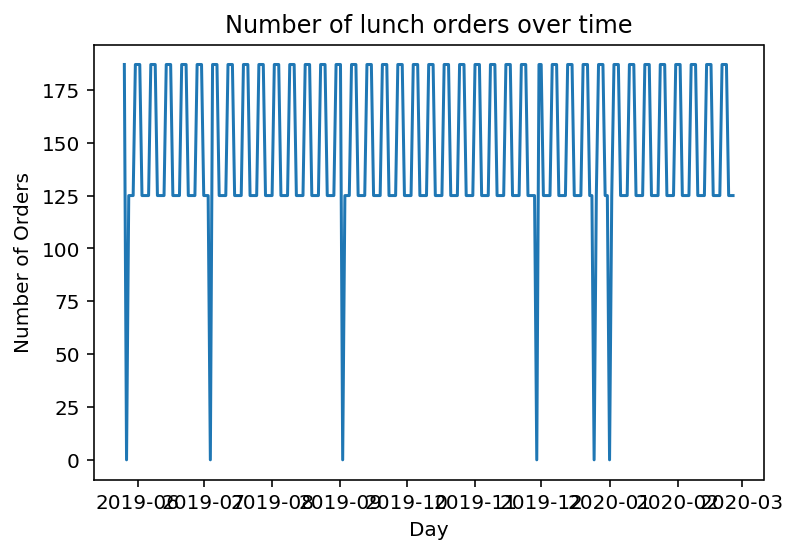

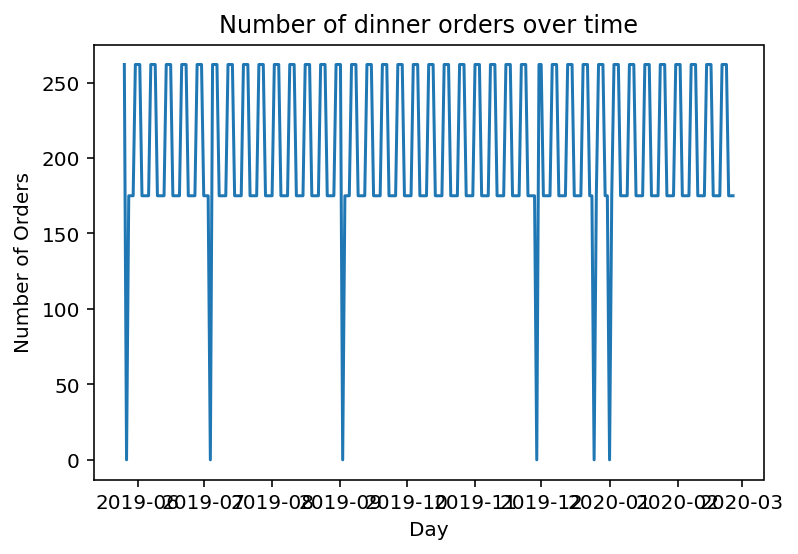


Showing dates where there are no orders
No orders on 2019-05-27 00:00:00 because closed
No orders on 2019-07-04 00:00:00 because closed
No orders on 2019-09-02 00:00:00 because closed
No orders on 2019-11-29 00:00:00 because closed
No orders on 2019-12-25 00:00:00 because closed
No orders on 2020-01-01 00:00:00 because closed


Ground truth weekend multiplier: 1.5
Weekend average: 445.1949152542373
Weekday average: 290.5660377358491
Calculated weekend multiplier: 1.5321643187321152

Successfully created the file titos_tacos_restaurant_location_5.csv with 98733 orders
Showing up to 10 orders
Successfully created the file titos_tacos_restaurant_location_5.txt with 98733 events


In [87]:
#if __name__ == "__main__":

# create the instance 
filename = "titos_tacos_restaurant_location_5_parameters.txt"
parameters = text_to_dict(filename)
titos_tacos_location = Restaurant(parameters)

# generate orders 
csv_orders, json_events= titos_tacos_location.generate_orders(csv=True, json=True)

# write to csv and json 
write_to_csv(csv_orders, "titos_tacos_restaurant_location_5.csv")
write_to_json(json_events, "titos_tacos_restaurant_location_5.txt")